### Imports

In [1]:
import time
import random
import json
from tqdm import tqdm
import os
import pickle

import torch
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
from torchdata.datapipes.iter import IterableWrapper

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table

from utils.batch import BatchSamplerSimilarLength, collate_batch
from utils.train import train_model, compute_accuracy
from utils.plot import plot_accuracy, plot_training_loss

from models.lstm import LSTM

### Settings and Hyperparameters

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 16
NUM_EPOCHS = 30
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_CLASSES = 3

### Define Tokenizer

In [3]:
def custom_tokenizer(line):
    line = line.lower()
    line = line.replace(',', ' ')
    line = line.replace('\\', ' ')
    line = line.replace('\\\\', ' ')
    return line.split()

tokenizer = get_tokenizer(tokenizer=custom_tokenizer)

### Load Data

In [4]:
# check if json files exist
if not os.path.isfile('reports.json'):
    # connect to database
    engine = create_engine(db_uri)

    # load tables
    metadata_obj = MetaData()
    conn = engine.connect()

    Tag = Table('tag', metadata_obj, autoload_with=engine)
    SampleTag = Table('sample_tag', metadata_obj, autoload_with=engine)
    Analysis = Table('analysis', metadata_obj, autoload_with=engine)

    # Start a session
    session = Session(engine)

    # get all reports with the tag 'file_search_dfs'
    stmt = select(Analysis.c.report).join(SampleTag, Tag.c.id == SampleTag.c.tag_id).join(
        Analysis, SampleTag.c.sample_id == Analysis.c.sample).where(
        Tag.c.value == 'file_search_dfs'
    )

    results = session.execute(stmt).fetchall()
    dfs_report_paths = [r[0] for r in results] 

    # get all reports with the tag 'file_search_bfs'
    stmt = select(Analysis.c.report).join(SampleTag, Tag.c.id == SampleTag.c.tag_id).join(
        Analysis, SampleTag.c.sample_id == Analysis.c.sample).where(
        Tag.c.value == 'file_search_bfs'
    )

    results = session.execute(stmt).fetchall()
    bfs_report_paths = [r[0] for r in results]

    # Close the session
    session.close()

    # fetch reports
    bfs_reports = []
    for report_path in tqdm(bfs_report_paths, desc="Reading BFS reports"):
        with open(report_path) as f:
            bfs_reports.append(f.read())

    dfs_reports = []
    for report_path in tqdm(dfs_report_paths, desc="Reading DFS reports"):
        with open(report_path) as f:
            dfs_reports.append(f.read())

    # combine reports
    reports = [[r, 'bfs'] for r in bfs_reports] + [[r, 'dfs'] for r in dfs_reports]

    # shuffle reports
    random.shuffle(reports)

    # Tokenize reports
    i = 0
    for report in tqdm(reports, desc="Tokenizing reports"):
        dynamic_report = json.loads(report[0])['dynamic']
        dynamic_report_tokenized = []
        for item in dynamic_report:
            line = f"{item['Operation']}, {item['Path']}, {item['Result']}"
            dynamic_report_tokenized.extend(tokenizer(line))
        reports[i][0] = dynamic_report_tokenized
        i += 1

    # json dump reports to file
    print("Dumping reports to file")
    with open('reports.json', 'w') as f:
        json.dump(reports, f)

else:
    print("Loading reports from file")
    # load reports from file
    with open('reports.json') as f:
        reports = json.load(f)

Loading reports from file


In [5]:
# remove any reports with less than 100 tokens or more than 10000 tokens
reports = [r for r in reports if len(r[0]) > 100 and len(r[0]) < 10000]

# shuffle reports
random.shuffle(reports)

### Split Data

In [6]:
# Split into training, validation, and test sets
dp = IterableWrapper(reports)

# Get the number of rows in dataset
N_ROWS = len(list(dp)) 
N_train = int(N_ROWS * 0.8)
N_valid = int(N_ROWS * 0.1)
N_test = N_ROWS - N_train - N_valid

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = dp.random_split(total_length=N_ROWS, weights={"train": N_train, "valid": N_valid, "test": N_test}, seed=RANDOM_SEED)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 21683
Num Validate: 2710
Num Test: 2711


### Build Vocabulary

In [7]:
# build vocab
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield text

vocab = build_vocab_from_iterator(yield_tokens(train_dp), specials=["<unk>", "<pad>"], max_tokens=VOCABULARY_SIZE)
vocab.set_default_index(vocab["<unk>"])
PADDING_VALUE=vocab['<PAD>']

### Define text and label transforms

In [8]:
text_transform = lambda x: [vocab[token] for token in x]

# label transform for three classes
label_transform = lambda x: 0 if x == 'bfs' else 1 if x == 'dfs' else 2

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform(list(train_dp)[0][0]))

input to the text_transform: here is an example
output of the text_transform: [110, 158, 2, 61, 114, 2, 46, 45, 3, 4, 5, 6, 7, 8, 56, 2, 46, 45, 3, 19, 34, 136, 2, 17, 3, 19, 54, 55, 2, 135, 3, 19, 54, 55, 2, 28, 3, 19, 54, 55, 2, 28, 3, 19, 54, 55, 2, 18, 3, 19, 54, 55, 2, 21, 13, 14, 15, 16, 36, 35, 40, 21, 13, 14, 15, 16, 36, 35, 2, 33, 13, 14, 15, 16, 36, 35, 152, 31, 29, 30, 39, 13, 14, 15, 16, 36, 35, 2, 21, 13, 14, 15, 16, 36, 35, 119, 118, 40, 21, 13, 14, 15, 16, 36, 35, 119, 118, 31, 29, 30, 21, 13, 14, 15, 16, 36, 35, 40, 21, 13, 14, 15, 16, 36, 35, 2, 33, 13, 14, 15, 16, 36, 35, 109, 31, 29, 30, 39, 13, 14, 15, 16, 36, 35, 2, 17, 3, 4, 5, 6, 7, 8, 2, 46, 45, 3, 19, 34, 153, 2, 46, 45, 3, 19, 34, 149, 2, 33, 13, 14, 15, 16, 62, 60, 160, 31, 29, 30, 21, 13, 14, 15, 16, 128, 126, 125, 40, 21, 13, 14, 15, 16, 128, 126, 125, 31, 29, 30, 33, 13, 14, 15, 16, 62, 60, 159, 31, 29, 30, 21, 13, 14, 15, 16, 67, 66, 40, 21, 13, 14, 15, 16, 67, 66, 2, 33, 13, 14, 15, 16, 67, 66, 173, 31, 

In [9]:
# batching wrapper
def collate_batch_wrapper(batch):
    return collate_batch(batch=batch, 
                  padding_value=PADDING_VALUE, 
                  device=DEVICE, 
                  text_transform=text_transform, 
                  label_transform=label_transform)

# set up dataloaders
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list, 
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch_wrapper)
valid_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch_wrapper)
test_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch_wrapper)

text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([5052, 16])
torch.Size([16])


In [10]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([5203, 16])
Target vector size: torch.Size([16])

Valid:
Text matrix size: torch.Size([5219, 16])
Target vector size: torch.Size([16])

Test:
Text matrix size: torch.Size([5219, 16])
Target vector size: torch.Size([16])


### Train Model

In [11]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/030 | Batch 0000/1355 | Loss: 1.0741
Epoch: 001/030 | Batch 0100/1355 | Loss: 1.1847
Epoch: 001/030 | Batch 0200/1355 | Loss: 0.8824
Epoch: 001/030 | Batch 0300/1355 | Loss: 1.1618
Epoch: 001/030 | Batch 0400/1355 | Loss: 0.9930
Epoch: 001/030 | Batch 0500/1355 | Loss: 0.8024
Epoch: 001/030 | Batch 0600/1355 | Loss: 0.9446
Epoch: 001/030 | Batch 0700/1355 | Loss: 0.8902
Epoch: 001/030 | Batch 0800/1355 | Loss: 0.9925
Epoch: 001/030 | Batch 0900/1355 | Loss: 1.1893
Epoch: 001/030 | Batch 1000/1355 | Loss: 0.9697
Epoch: 001/030 | Batch 1100/1355 | Loss: 1.0167
Epoch: 001/030 | Batch 1200/1355 | Loss: 0.9535
Epoch: 001/030 | Batch 1300/1355 | Loss: 1.1389
Epoch: 001/030 | Train: 42.70% | Validation: 42.25%
Time elapsed: 8.10 min
Epoch: 002/030 | Batch 0000/1355 | Loss: 1.3545
Epoch: 002/030 | Batch 0100/1355 | Loss: 1.0602
Epoch: 002/030 | Batch 0200/1355 | Loss: 1.0419
Epoch: 002/030 | Batch 0300/1355 | Loss: 1.1346
Epoch: 002/030 | Batch 0400/1355 | Loss: 1.1050
Epoch: 002/03

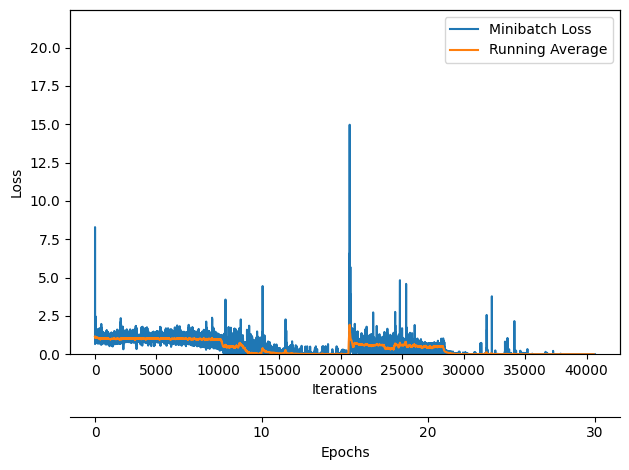

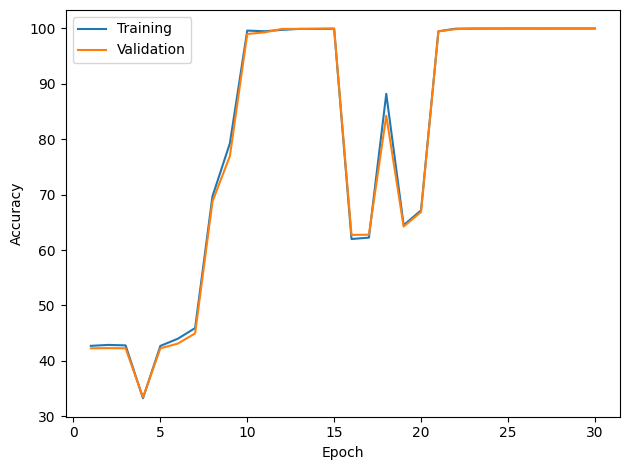

In [12]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

In [13]:
# save model, vocab, and optimizer state
torch.save(model.state_dict(), 'model_data/lstm_03.pt')
torch.save(optimizer.state_dict(), 'model_data/optimizer_03.pt')

# save the vocab
with open('model_data/vocab_03.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [14]:
def get_prediction(model, sentence):

    with torch.no_grad():
        model.eval()
        if type(sentence) == str:
            tokenized = tokenizer(sentence)
        elif type(sentence) == list:
            tokenized = sentence
        else:
            raise TypeError('sentence must be str or list')
        indexed = [vocab[t] for t in tokenized]
        # print(indexed)
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(DEVICE)
        tensor = tensor.unsqueeze(1)
        prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

In [15]:
for i in range(100):
    report = random.choice(test_dp_list)
    prediction = get_prediction(model, report[0])
    print(f"Report: {label_transform(report[1])}, Prediction: {prediction.argmax()}, {prediction}")

Report: 1, Prediction: 1, [2.3320599e-03 9.9766797e-01 1.1738101e-12]
Report: 0, Prediction: 0, [9.9999547e-01 2.6538144e-06 1.9276169e-06]
Report: 0, Prediction: 0, [9.9999547e-01 2.6258697e-06 1.9341978e-06]
Report: 1, Prediction: 1, [4.264225e-06 9.999957e-01 5.163886e-14]
Report: 1, Prediction: 1, [4.264225e-06 9.999957e-01 5.163886e-14]
Report: 2, Prediction: 2, [2.3491873e-05 1.6051887e-11 9.9997652e-01]
Report: 1, Prediction: 1, [4.264225e-06 9.999957e-01 5.163886e-14]
Report: 2, Prediction: 2, [6.4238453e-13 1.9703029e-17 1.0000000e+00]
Report: 0, Prediction: 0, [9.9999547e-01 2.6538144e-06 1.9276169e-06]
Report: 1, Prediction: 1, [2.3320951e-03 9.9766785e-01 1.1738190e-12]
Report: 0, Prediction: 0, [9.9999547e-01 2.6538166e-06 1.9276793e-06]
Report: 1, Prediction: 1, [4.264225e-06 9.999957e-01 5.163886e-14]
Report: 0, Prediction: 0, [9.9999547e-01 2.6538166e-06 1.9276793e-06]
Report: 0, Prediction: 0, [9.9999547e-01 2.6538166e-06 1.9276793e-06]
Report: 1, Prediction: 1, [4.264